In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import torch

In [2]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [3]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_plateau_length(steps: List[Dict], threshold: float = 0.01) -> int:
    kl_divs = [step["kl_div"] for step in steps]
    slopes = [kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1)]

    for i, slope in enumerate(slopes):
        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def find_kl_div_blowup(steps: List[Dict], threshold: float = 0.5) -> Tuple[int, float]:
    for step in steps:
        if step["kl_div"] >= threshold:
            return step["step"]
    return len(steps)

In [4]:
metadata, activations = [], []

for path in glob("observations/metadata*"):
    metadata.extend(load_jsonl(path))

for path in glob("observations/acts*"):
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [6]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

In [7]:
def compute_sensitivity(kl_div, threshold=0.5):
    exceeded = kl_div > threshold
    if exceeded.any():
        return (exceeded == True).nonzero(as_tuple=True)[0][0].item()
    else:
        return len(kl_div) - 1


def get_sae_feature_directions(sae, metadata):
    feature_dirs = []
    for m in metadata:
        obs_feature_dirs = []
        active_feature_ids_start = m["steps_metadata"][0]["active_feature_ids"]
        active_feature_acts_start = m["steps_metadata"][0]["active_feature_acts"]

        sorted_feature_ids_with_acts = sorted(
            zip(active_feature_ids_start, active_feature_acts_start),
            key=lambda t: t[1],
            reverse=True,
        )

        for feature_id, feature_act in sorted_feature_ids_with_acts[:5]:
            feature_dir = get_feature_dir(sae, feature_id, feature_act, norm=True)
            obs_feature_dirs.append(feature_dir)

        # active_feature_ids_end = m['steps_metadata'][-1]['active_feature_ids']
        # active_feature_acts_end = m['steps_metadata'][-1]['active_feature_acts']

        # for feature_id, feature_act in zip(active_feature_ids_end, active_feature_acts_end):
        #     feature_dir = get_feature_dir(sae, feature_id, feature_act, norm=True)
        #     obs_feature_dirs.append(feature_dir)

        feature_dirs.append(obs_feature_dirs)

    return feature_dirs

In [8]:
kl_divs = [[s["kl_div"] for s in m["steps_metadata"]] for m in metadata]

In [9]:
sae_feature_dirs = get_sae_feature_directions(sae, metadata)

In [10]:
len(sae_feature_dirs[0])

5

In [16]:
alignments = []
sensitivities = []
perturbation_magnitudes = []

for acts, feature_dirs, kl in zip(activations, sae_feature_dirs, kl_divs):
    # Compute perturbation direction
    perturbation = torch.tensor(acts[-1] - acts[0])
    # perturbation = perturbation / perturbation.norm()

    perturbation_magnitude = torch.norm(perturbation).item()
    perturbation_magnitudes.append(perturbation_magnitude)

    # Compute alignments with each SAE feature direction
    feature_alignments = torch.tensor(
        [torch.dot(direction, perturbation).abs().item() for direction in feature_dirs]
    )

    # Use the maximum alignment
    max_alignment = feature_alignments.max().item()
    alignments.append(max_alignment)

    sens = compute_sensitivity(torch.tensor(kl))
    sensitivities.append(sens)

In [17]:
correlation, p_value = stats.pearsonr(alignments, sensitivities)

# Compare to random directions
random_alignments = [
    max(
        [
            torch.dot(torch.randn_like(perturbation), perturbation).abs().item()
            for _ in range(len(feature_dirs))
        ]
    )
    for _ in range(len(alignments))
]
t_stat, p_value_random = stats.ttest_ind(alignments, random_alignments)

results = {
    "alignment_sensitivity_correlation": correlation,
    "correlation_p_value": p_value,
    "t_statistic_vs_random": t_stat,
    "p_value_vs_random": p_value_random,
    "mean_max_alignment": np.mean(alignments),
    "std_max_alignment": np.std(alignments),
    "mean_perturbation_magnitude": np.mean(perturbation_magnitudes),
    "std_perturbation_magnitude": np.std(perturbation_magnitudes),
    "alignment_magnitude_correlation": stats.pearsonr(
        alignments, perturbation_magnitudes
    )[0],
}

In [18]:
results

{'alignment_sensitivity_correlation': -0.0009218807296072287,
 'correlation_p_value': 0.9480382274297953,
 't_statistic_vs_random': -174.99333208047682,
 'p_value_vs_random': 0.0,
 'mean_max_alignment': 0.5963994953611865,
 'std_max_alignment': 0.626851879032859,
 'mean_perturbation_magnitude': 3.811590401315689,
 'std_perturbation_magnitude': 0.8020317065964,
 'alignment_magnitude_correlation': 0.2246505346706908}

In [ ]:
# Results for all active features
# {'alignment_sensitivity_correlation': -0.0018401789796013025,
#  'correlation_p_value': 0.8964968991374137,
#  't_statistic_vs_random': -407.57666071332915,
#  'p_value_vs_random': 0.0,
#  'mean_max_alignment': 0.5983612892946228,
#  'std_max_alignment': 0.6257981130192137,
#  'mean_perturbation_magnitude': 3.811590401315689,
#  'std_perturbation_magnitude': 0.8020317065964,
#  'alignment_magnitude_correlation': 0.22568039140849389}

### Investigating individual feature ablations

In [75]:
def analyze_top_feature_ablation(
    initial_activations, final_activations, sae_feature_directions, sensitivities
):
    n_samples, n_features, _ = sae_feature_directions.shape

    # Compute SAE feature activations for initial and final states
    initial_sae_activations = np.array(
        [
            np.abs(np.dot(initial_activations[i], sae_feature_directions[i].T))
            for i in range(n_samples)
        ]
    )
    final_sae_activations = np.array(
        [
            np.abs(np.dot(final_activations[i], sae_feature_directions[i].T))
            for i in range(n_samples)
        ]
    )

    # Compute feature ablation (negative values indicate ablation)
    feature_changes = final_sae_activations - initial_sae_activations

    # Analyze ablation of top features
    top_feature_ablations = (
        -feature_changes
    )  # Negative so that positive values represent ablation

    # Compute correlations for top features
    results = []
    for i in range(n_features):
        corr, p_value = stats.pearsonr(top_feature_ablations[:, i], sensitivities)
        results.append({"feature": i + 1, "correlation": corr, "p_value": p_value})
        print(f"Top feature {i+1}: Correlation = {corr:.4f}, P-value = {p_value:.4e}")

    # Multiple regression with top feature ablations
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score

    X = top_feature_ablations
    y = sensitivities

    model = LinearRegression()
    cv_scores = cross_val_score(model, X, y, cv=5)

    print("\nMultiple Regression Results:")
    print(
        f"Mean R-squared (5-fold CV): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}"
    )

    # Fit the model on all data to get coefficients
    model.fit(X, y)
    for i, coef in enumerate(model.coef_):
        print(f"Top Feature {i+1} Coefficient: {coef:.4f}")

    # Scatter plot of ablation vs sensitivity for all features, colored by feature
    plt.figure(figsize=(12, 8))
    colors = ["r", "g", "b", "c", "m"]
    for i in range(n_features):
        plt.scatter(
            top_feature_ablations[:, i],
            sensitivities,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=f"Feature {i+1}",
            s=10,
        )

    plt.xlabel("Feature Ablation")
    plt.ylabel("Sensitivity")
    plt.title("Sensitivity vs Ablation of Top Features")
    plt.legend()

    # Add text annotations for correlations
    for i, result in enumerate(results):
        plt.annotate(
            f"F{i+1}: r={result['correlation']:.2f}, p={result['p_value']:.2e}",
            xy=(0.05, 0.95 - i * 0.05),
            xycoords="axes fraction",
            ha="left",
            va="top",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    return results

In [84]:
initial_activations, final_activations = activations[:, 0, :], activations[:, -1, :]
sae_feature_directions = torch.stack([torch.stack(fd) for fd in sae_feature_dirs])
sensitivities = [compute_sensitivity(torch.tensor(kl)) for kl in kl_divs]

Top feature 1: Correlation = -0.0168, P-value = 2.3457e-01
Top feature 2: Correlation = 0.0756, P-value = 8.7451e-08
Top feature 3: Correlation = 0.1149, P-value = 3.6299e-16
Top feature 4: Correlation = 0.1092, P-value = 9.7861e-15
Top feature 5: Correlation = 0.1216, P-value = 6.2175e-18

Multiple Regression Results:
Mean R-squared (5-fold CV): -0.0070 ± 0.0208
Top Feature 1 Coefficient: -0.4542
Top Feature 2 Coefficient: -0.5923
Top Feature 3 Coefficient: 1.2428
Top Feature 4 Coefficient: -6.0965
Top Feature 5 Coefficient: 10.7525


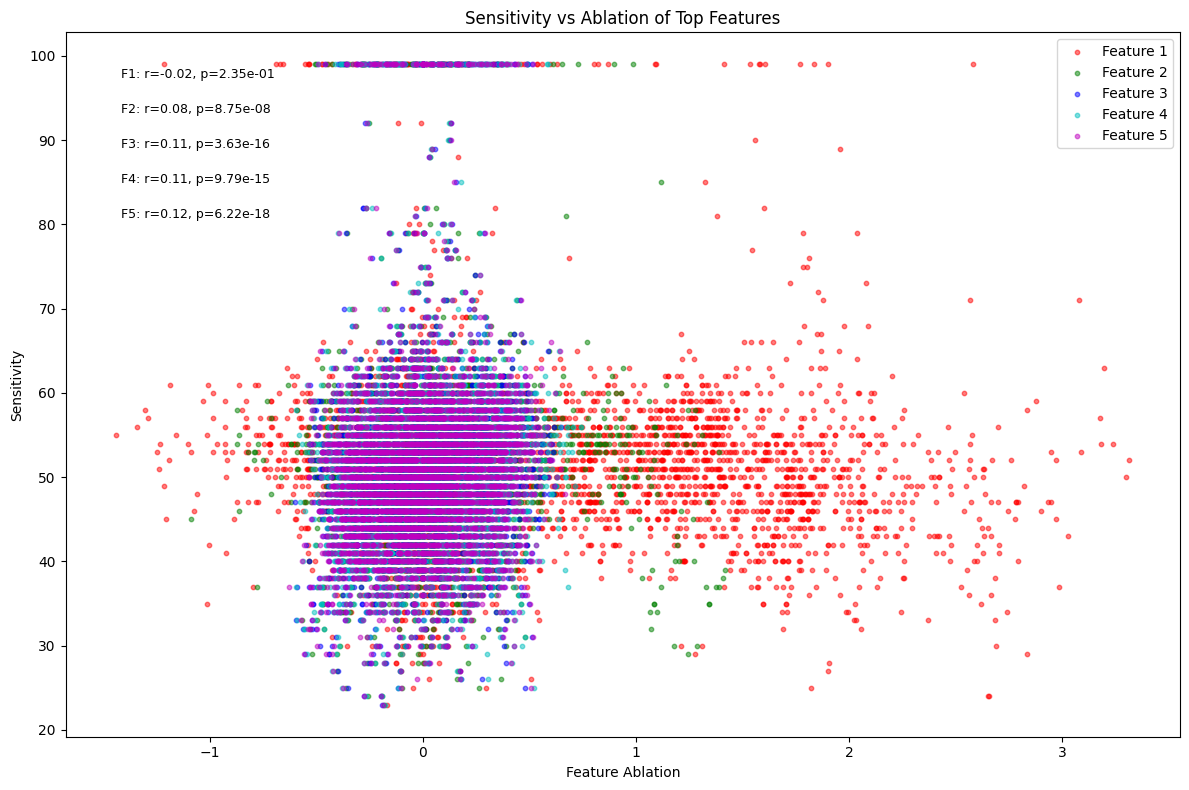

In [85]:
results = analyze_top_feature_ablation(
    initial_activations,
    final_activations,
    sae_feature_directions.detach(),
    sensitivities,
)

### Investigating pairwise feature ablation

In [86]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations


def analyze_feature_pair_ablation(
    initial_activations, final_activations, sae_feature_directions, sensitivities
):
    n_samples, n_features, _ = sae_feature_directions.shape

    # Compute SAE feature activations for initial and final states
    initial_sae_activations = np.array(
        [
            np.abs(np.dot(initial_activations[i], sae_feature_directions[i].T))
            for i in range(n_samples)
        ]
    )
    final_sae_activations = np.array(
        [
            np.abs(np.dot(final_activations[i], sae_feature_directions[i].T))
            for i in range(n_samples)
        ]
    )

    # Compute feature ablation (negative values indicate ablation)
    feature_ablations = initial_sae_activations - final_sae_activations

    # Analyze ablation of feature pairs
    results = []
    for i, j in combinations(range(n_features), 2):
        pair_ablation = feature_ablations[:, i] + feature_ablations[:, j]
        corr, p_value = stats.pearsonr(pair_ablation, sensitivities)
        results.append(
            {"features": (i + 1, j + 1), "correlation": corr, "p_value": p_value}
        )
        print(
            f"Features {i+1} & {j+1}: Correlation = {corr:.4f}, P-value = {p_value:.4e}"
        )

    # Multiple regression with all feature pair ablations
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score

    X = np.array(
        [
            feature_ablations[:, i] + feature_ablations[:, j]
            for (i, j) in combinations(range(n_features), 2)
        ]
    ).T
    y = sensitivities

    model = LinearRegression()
    cv_scores = cross_val_score(model, X, y, cv=5)

    print("\nMultiple Regression Results:")
    print(
        f"Mean R-squared (5-fold CV): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}"
    )

    # Scatter plot for the most significant feature pair
    best_pair = max(results, key=lambda x: abs(x["correlation"]))
    i, j = best_pair["features"]
    pair_ablation = feature_ablations[:, i - 1] + feature_ablations[:, j - 1]

    plt.figure(figsize=(10, 6))
    plt.scatter(pair_ablation, sensitivities, alpha=0.5)
    plt.xlabel(f"Combined Ablation of Features {i} & {j}")
    plt.ylabel("Sensitivity")
    plt.title(
        f"Sensitivity vs Combined Ablation of Features {i} & {j}\n"
        f"Correlation: {best_pair['correlation']:.4f}, p-value: {best_pair['p_value']:.4e}"
    )
    plt.tight_layout()
    plt.show()

    return results

Features 1 & 2: Correlation = 0.0096, P-value = 4.9748e-01
Features 1 & 3: Correlation = 0.0160, P-value = 2.5779e-01
Features 1 & 4: Correlation = 0.0151, P-value = 2.8591e-01
Features 1 & 5: Correlation = 0.0186, P-value = 1.8951e-01
Features 2 & 3: Correlation = 0.0973, P-value = 5.4032e-12
Features 2 & 4: Correlation = 0.0944, P-value = 2.2057e-11
Features 2 & 5: Correlation = 0.1017, P-value = 5.6522e-13
Features 3 & 4: Correlation = 0.1127, P-value = 1.3329e-15
Features 3 & 5: Correlation = 0.1190, P-value = 3.1175e-17
Features 4 & 5: Correlation = 0.1162, P-value = 1.7031e-16

Multiple Regression Results:
Mean R-squared (5-fold CV): -0.0076 ± 0.0207


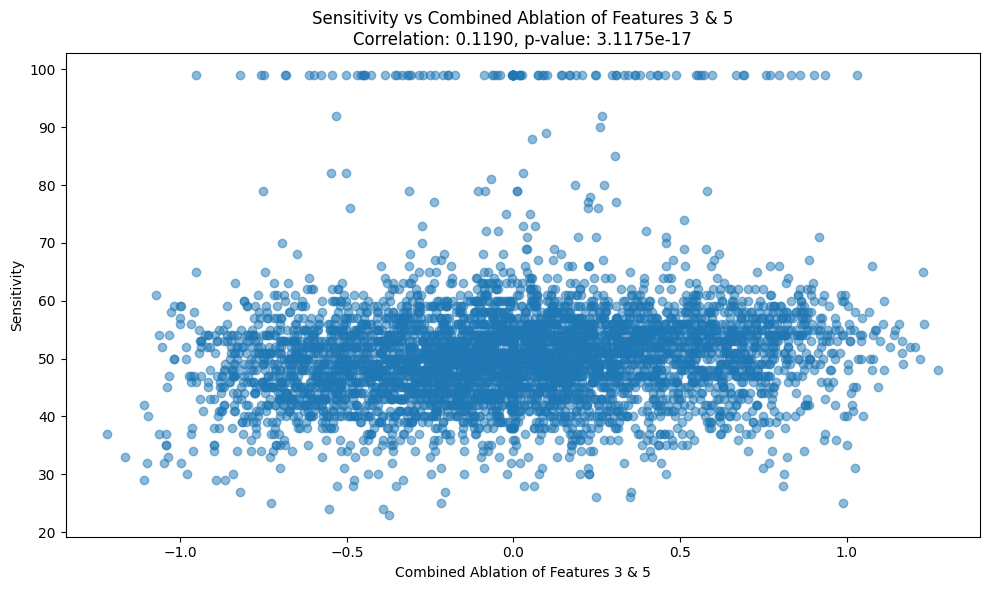

In [87]:
results = analyze_feature_pair_ablation(
    initial_activations,
    final_activations,
    sae_feature_directions.detach(),
    sensitivities,
)

### Plotting

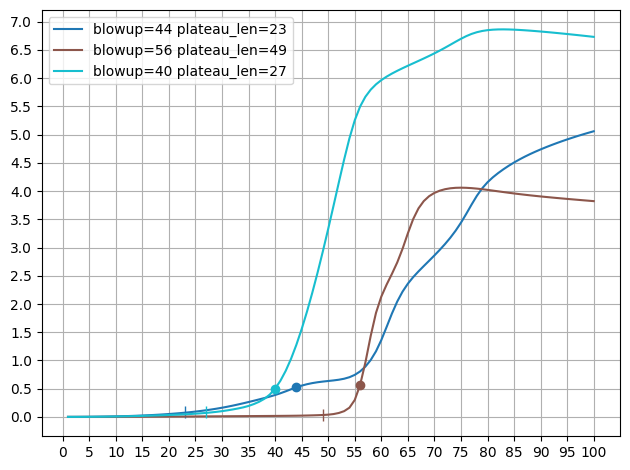

In [87]:
obs_idxs = [0, 10, 20]
steps = np.arange(1, 101, 1)

max_kl = 0

# Get the colormap
cmap = plt.get_cmap("tab10")
colors = cmap(np.linspace(0, 1, len(obs_idxs)))

for i, obs_idx in enumerate(obs_idxs):
    props = metadata[obs_idx]
    kl_divs = [s["kl_div"] for s in props["steps_metadata"]]
    max_kl = max(max_kl, max(kl_divs))
    blowup_step = find_kl_div_blowup(props["steps_metadata"])
    plateau_len = find_plateau_length(props["steps_metadata"])
    label = f"blowup={blowup_step} plateau_len={plateau_len}"
    plt.plot(steps, kl_divs, label=label, color=colors[i])
    plt.plot(
        blowup_step,
        np.interp(blowup_step, steps, kl_divs),
        marker="o",
        markersize=6,
        color=colors[i],
    )
    plt.plot(
        plateau_len, kl_divs[plateau_len], marker="|", markersize=8, color=colors[i]
    )

plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.arange(0, max_kl + 0.5, 0.5))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()